In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Setup
from dotenv import load_dotenv
import os
from langchain_core.messages import HumanMessage
from graph.trivial_agent_graph import IndexerAgentGraphBuilder
from agents.IndexerAgent import indexer_agent_model, tool_executor
from tools.JavaScriptRunner import tool_js_on_block_schema_func, tool_js_on_block_schema
from agents.BlockExtractorAgent import run_js_on_block_only_schema,JsResponse
import json

# Load .env file
load_dotenv('.env')

# Set model variables
OPENAI_BASE_URL = "https://api.openai.com/v1"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

/Users/spark_near/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage

# Define Graphstate
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages: With user questions, tracking plans, reasoning
        block_heights: Block heights of the blocks to be parsed
        js_code: Javascript code to be run on block schema
        block_schema: Extracted block schema from json of blocks 
        ddl_code: Data Definition Language code for creating tables
        dml_code: Data manipulation language code for inserting data using context.db
        iterations: Number of tries to generate the code
        error: error message if any
        should_continue: Binary flag for control flow to indicate whether to continue or not
    """

    messages: Sequence[BaseMessage]
    block_heights: Sequence[int]
    block_schema: str
    js_code: str
    ddl_code: str
    dml_code: str
    iterations: int
    error: str
    should_continue: bool

In [18]:
# Load agents
from tools.NearLake import tool_get_block_heights
from agents.BlockExtractorAgent import BlockExtractorAgent,block_extractor_agent_model_v2
from agents.DDLAgent import DDLCodeAgent,ddl_code_model_v2,DDLResponse
from langgraph.prebuilt import ToolExecutor

# Block Extractor Agent
block_extractor_tools = [tool_js_on_block_schema_func] #, tool_get_block_heights]
block_extractor_model = block_extractor_agent_model_v2(block_extractor_tools)
block_extractor_agent = BlockExtractorAgent(block_extractor_model,ToolExecutor(block_extractor_tools))

# DDL Agent
ddl_tools= [] #[tool_js_on_block_schema]
ddl_code_agent_model = ddl_code_model_v2(ddl_tools)
ddl_code_agent = DDLCodeAgent(ddl_code_agent_model,ToolExecutor(ddl_tools))

In [19]:
# Conditional Edge logic
def should_block_schema_continue(state):
    last_message = state["messages"][-1]
    messages = state["messages"]
    if hasattr(last_message, 'additional_kwargs'):
        if "tool_calls" in last_message.additional_kwargs:
            return "continue"
        else:
            return "end"
    else:
        return "end"
    
def block_schema_review_continue(state):
    should_continue = state['should_continue']
    block_schema = state['block_schema']
    iterations = state['iterations']
    if should_continue == True:
        return "continue"
    elif iterations > 3:
        return "end"
    elif block_schema == "":
        return "repeat"
    else:
        return "end"
    

In [20]:
## Create Final Graph (will move this to another file ultimately)
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("block_extractor_agent", block_extractor_agent.call_model)  # Plan the process
workflow.add_node("ddl_code_agent", ddl_code_agent.call_model)  # Plan the process

## Tool Nodes
workflow.add_node("get_block_schema",block_extractor_agent.call_tool)
workflow.add_node("parse_blocks",ddl_code_agent.call_tool)

## Human Review
workflow.add_node("review_schema",block_extractor_agent.human_review)

## Add Edges
workflow.set_entry_point("block_extractor_agent")
workflow.add_edge("get_block_schema", "review_schema")
workflow.add_edge("parse_blocks", "ddl_code_agent")

# Add Conditional Edges
# Check if all block extraction tools are completed
workflow.add_conditional_edges(
    "block_extractor_agent",
    should_block_schema_continue,
    {
        "continue":"get_block_schema",
        "end": "ddl_code_agent"
    }   
)
# Check if block schema is correct via human review
workflow.add_conditional_edges(
    "review_schema",
    block_schema_review_continue,
    {
        "continue":"ddl_code_agent",
        "repeat": "block_extractor_agent",
        "end": END
    }   
)
# Check if DDL has finished tool calls
workflow.add_conditional_edges(
    "ddl_code_agent",
    should_block_schema_continue,
    {
        "continue":"parse_blocks",
        "end": END
    }   
)

app = workflow.compile()

In [14]:
# from langchain_core.messages import HumanMessage

# question = """
#     Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, 
#     I need signerId, block height, receiptId, block datetime, methodName. Also add all fields from 
#     args that are decoded from base64-encoded JSON. I only need actions for successful receipts.
# """

# result = app.invoke({"messages": [HumanMessage(content=question)], 
#                      "block_schema": "",
#                      "js_code":"",
#                      "ddl_code":"",
#                      "dml_code": "",
#                      "iterations": 0,
#                      "error":"",
#                      "should_continue": False,
#                      })

# print(result)

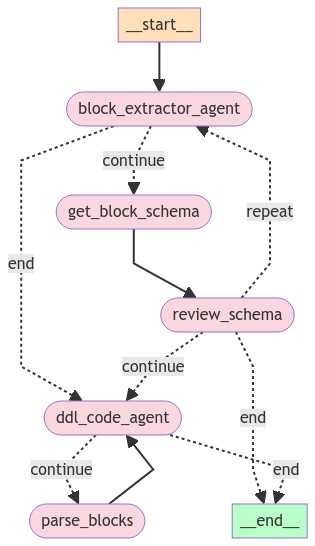

In [14]:
# Visualization
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [21]:
def ddl_code_agent_router(state):
    ddl_code = state['ddl_code']
    iterations = state['iterations']
    last_message = state["messages"][-1]
    if hasattr(last_message, 'additional_kwargs'):
        if "tool_calls" in last_message.additional_kwargs:
            return "parse_blocks"
        else:
            return "review_ddl"
    elif iterations > 3:
        return "end"
    elif ddl_code == "":
        return "ddl_code_agent"
    else:
        return "end"

## Create DDL Graph
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("ddl_code_agent", ddl_code_agent.call_model)  # Plan the process

## Tool Nodes
workflow.add_node("parse_blocks",ddl_code_agent.call_tool)

## Human Review
workflow.add_node("review_ddl",ddl_code_agent.human_review)

## Add Edges
workflow.set_entry_point("ddl_code_agent")
workflow.add_edge("parse_blocks", "ddl_code_agent")
workflow.add_edge("review_ddl", END)

# Add Conditional Edges
# Check if all block extraction tools are completed
workflow.add_conditional_edges(
    "ddl_code_agent",
    ddl_code_agent_router,
    {
        "parse_blocks":"parse_blocks",
        "review_ddl":"review_ddl",
        "end": END,
    }   
)

ddl_app = workflow.compile()

In [22]:
from tools.JavaScriptRunner import run_js_on_block_only_schema, run_js_on_block
code = """
function extractData(block) {
    const actions = block.actions();
    const receipts = block.receipts();
    const header = block.header();

    const successfulReceipts = receipts.filter(receipt => receipt.status.SuccessValue);
    const filteredActions = actions.filter(action => action.receiverId === 'app.nearcrowd.near' && action.operations.some(op => op.FunctionCall));

    const result = [];

    for (const action of filteredActions) {
      for (const operation of action.operations) {
        if (operation.FunctionCall) {
          const receipt = receipts.find(receipt => receipt.receiptId === action.receiptId);
          if (receipt) {
            const args = JSON.parse(atob(operation.FunctionCall.args));
            result.push({
              signerId: action.signerId,
              blockHeight: header.height,
              receiptId: action.receiptId,
              receipt: receipt,
              blockDatetime: new Date(parseInt(header.timestampNanosec) / 1000000),
              methodName: operation.FunctionCall.methodName,
              ...args
            });
          }
        }
      }
    }

    return result;
  }
  return extractData(block);
"""
block_schema = json.dumps(run_js_on_block(119688212, code))
print(block_schema)

[{"signerId": "app.nearcrowd.near", "blockHeight": 119688212, "receiptId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "receipt": {"receiptKind": "Data", "receiptId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "receiverId": "app.nearcrowd.near", "predecessorId": "app.nearcrowd.near", "status": {"SuccessValue": ""}, "executionOutcomeId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "logs": []}, "blockDatetime": "2024-05-25T06:05:09.183Z", "methodName": "finalize_challenged_task", "task_ordinal": 1, "task_hash": [72, 71, 99, 6, 192, 125, 179, 117, 56, 229, 134, 171, 164, 113, 202, 224, 134, 94, 128, 164, 179, 16, 26, 219, 5, 213, 32, 80, 108, 145, 244, 169]}]


In [23]:
from langchain_core.messages import HumanMessage

question = f"""
    Take this block schema and generate DDL code to create normalized Postgresql tables for the data extracted from the block: {block_schema}
"""

result = ddl_app.invoke({"messages": [HumanMessage(content=question)], 
                     "block_schema": "",
                     "js_code":"",
                     "ddl_code":"",
                     "dml_code": "",
                     "iterations": 0,
                     "error":"",
                     "should_continue": False,
                     })

print(result)

{'messages': [HumanMessage(content='\n    Take this block schema and generate DDL code to create normalized Postgresql tables for the data extracted from the block: [{"signerId": "app.nearcrowd.near", "blockHeight": 119688212, "receiptId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "receipt": {"receiptKind": "Data", "receiptId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "receiverId": "app.nearcrowd.near", "predecessorId": "app.nearcrowd.near", "status": {"SuccessValue": ""}, "executionOutcomeId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "logs": []}, "blockDatetime": "2024-05-25T06:05:09.183Z", "methodName": "finalize_challenged_task", "task_ordinal": 1, "task_hash": [72, 71, 99, 6, 192, 125, 179, 117, 56, 229, 134, 171, 164, 113, 202, 224, 134, 94, 128, 164, 179, 16, 26, 219, 5, 213, 32, 80, 108, 145, 244, 169]}]\n'), AIMessage(content='{\n    "ddl": "CREATE TABLE IF NOT EXISTS block_data (\\n    id SERIAL PRIMARY KEY,\\n    signer_id VARCHAR(255),\\n    block_height 

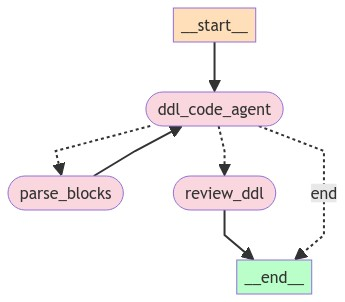

In [ ]:
# Visualization
from IPython.display import Image, display
display(Image(ddl_app.get_graph(xray=True).draw_mermaid_png()))